## Plot Heatmaps

In [1]:
import pandas as pd 
import numpy as np

import math, os

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("white")
from loess.loess_2d import loess_2d

pd.set_option('display.max_columns', 50)
#matplotlib inline
os.getcwd()


'/Users/chririn/Documents/Code/2D_analysis'

In [2]:
def front(self, n):
    return self.iloc[:, :n]

def back(self, n):
    return self.iloc[:, -n:]

pd.DataFrame.front = front
pd.DataFrame.back = back

# consider making this into a utility
# https://stackoverflow.com/questions/30608310/is-there-a-pandas-function-to-display-the-first-last-n-columns-as-in-head 

In [3]:
figformat = 'png'
dpi = 150

In [4]:
BaseDir = "results"
OutputDir = 'heatmaps'

if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)

## Load data

In [5]:
df = pd.read_csv('{}/colo44_cleaned_data.csv'.format(BaseDir), sep=';' , index_col=0)
df.back(27).head(1)

In [7]:
# Some information about the experiment
listOfPlates = df['barcode'].unique()
NrOfPlates = len(listOfPlates)
print('Number of plates: %s' %(NrOfPlates))
Wells = sorted(list(set(df['well_id'])))
NrOfWells = len(Wells)
print('Number of wells: %s' %(NrOfWells))
Rows = sorted(list(set([w[0] for w in Wells])))
print(*Rows)
NrOfRows = len(Rows)
Columns = sorted(list(set([w[1:] for w in Wells])))
NrOfColumns = len(Columns)
print(*Columns)

Number of plates: 4
Number of wells: 308
B C D E F G H I J K L M N O
02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23


#### The actual heatmaps

In [8]:
## Settings
FeaturesToPlot = ['ObjectNumber_cells', 'ObjectNumber_nuclei', 'Count_nuclei']
Co, Ro = 2, math.ceil(len(listOfPlates)/2)  # 2 columns
HeatmapSize = 3*len(listOfPlates), 2*len(listOfPlates)
wspace = 0.05
hspace = 0.4
top = 1
cmap='Reds' # Select color map, e.g. 'Reds', 'RdBu_r'
cmap2='Blues' # Select color map, e.g. 'Reds', 'RdBu_r'

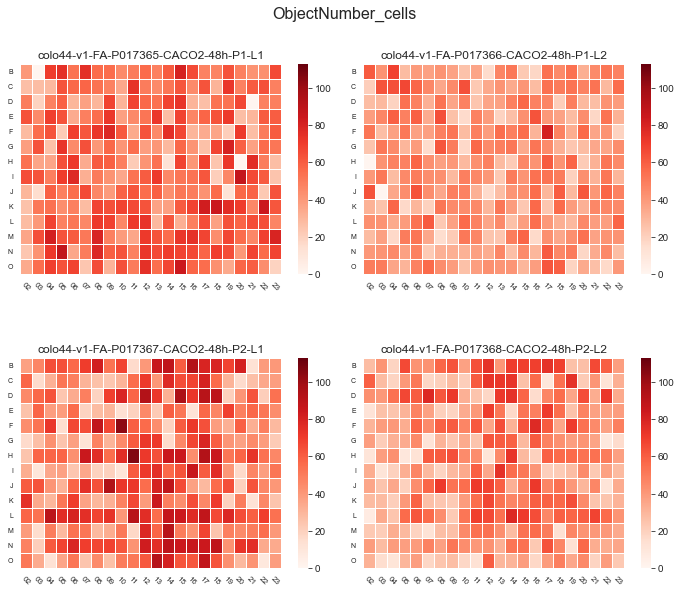

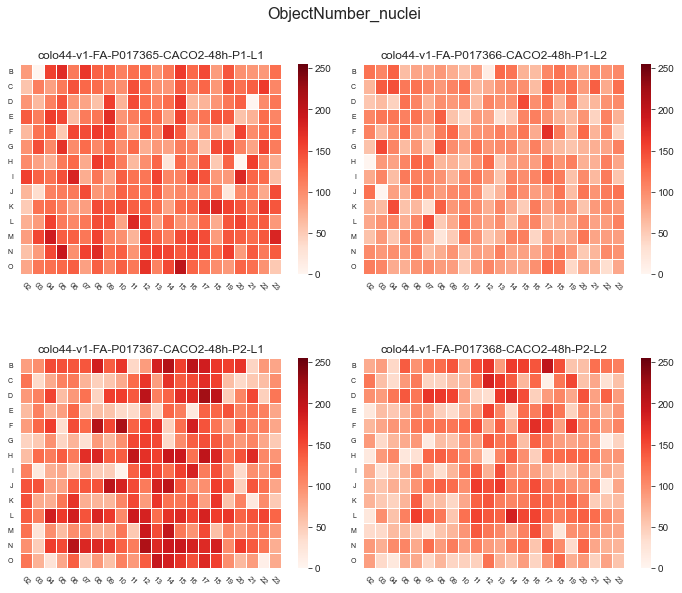

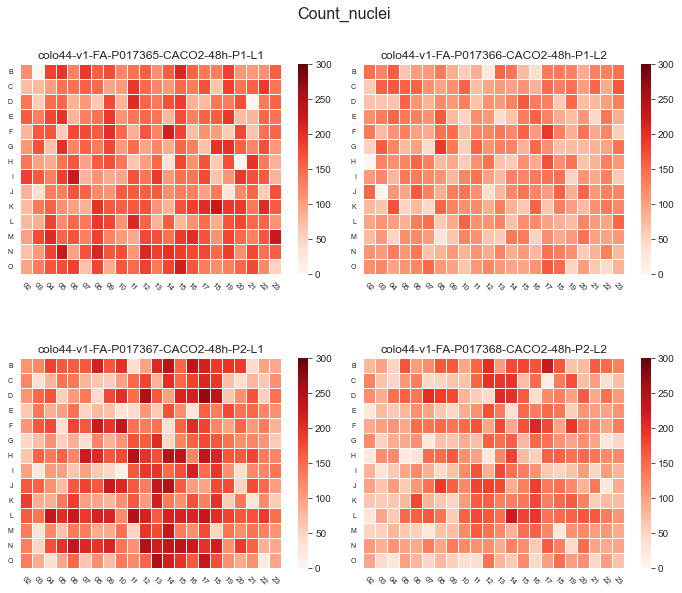

In [9]:
for feature in FeaturesToPlot[:]:
    fig = plt.figure(figsize = HeatmapSize) # Check if I can optimize the size for my purpose
    fig.suptitle('{}'.format(feature)  , fontsize = 16, y=1.1) 

    OneFeature = df[[feature, 'well_id', 'barcode']]

    # Set up the heatmap boundaries
    vmed = math.ceil(OneFeature[feature].quantile(0.5)*1000)/1000
    vmin = 0 

    n = 1 # subplot counter

    for OnePlate in listOfPlates:
        OneFeaturePerPlate = OneFeature[OneFeature['barcode'] == OnePlate]
        
        dictOfnumeric = {feature : np.median} 
        groupedby = OneFeaturePerPlate.groupby(['well_id']).agg(dictOfnumeric) # Aggregate to one value per well

        # Remove non-exisiting wells
        for W in Wells:
            if W not in groupedby.index:
                groupedby.loc[W] = 0
        groupedby.sort_index(inplace=True) 

        # Prepare the data for plotting
        groupedbyvalues = groupedby[feature].values.copy()
        groupedbyvalues.resize(NrOfRows,int(NrOfColumns))
        groupedbydf = pd.DataFrame(groupedbyvalues)
        groupedbydf.columns = Columns
        groupedbydf.index = Rows
        
        # Subplots
        ax = fig.add_subplot(Ro, Co , n)
        ax = sns.heatmap(groupedbydf, cmap=cmap,
                                     vmin = vmin,
                                     vmax = vmed * 2.5,
                                     square = False,
                                     linewidths = .5,
                                     xticklabels = 1, yticklabels = groupedbydf.index,
                                     )
        plt.yticks(fontsize=7,rotation=0)
        plt.xticks(fontsize=8,rotation= -45) 

        ax.set_title(OnePlate, fontsize = 12, loc = 'center')
        plt.subplots_adjust(  wspace = wspace, hspace = hspace, top = top)
        n += 1

    fig.savefig('{}/Heatmaps_{}_cmap_{}.{}'.format(OutputDir, feature, cmap, figformat),  dpi=dpi, bbox_inches='tight')

#### Heatmaps with clear DMSO controls 

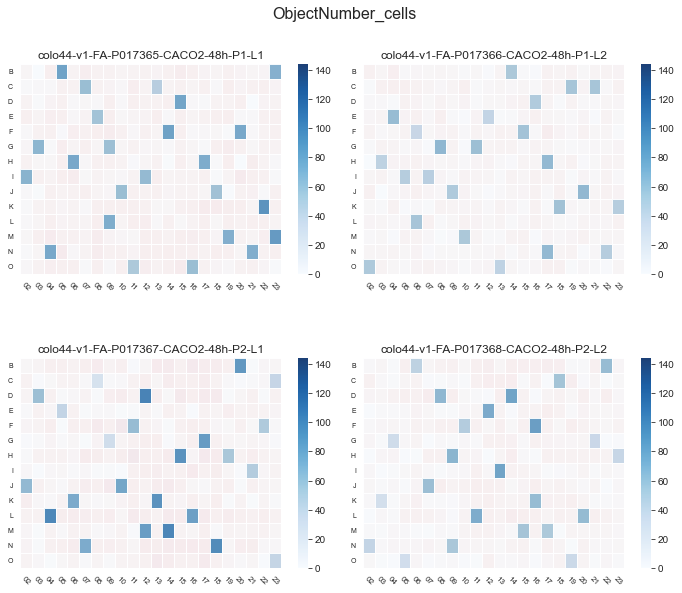

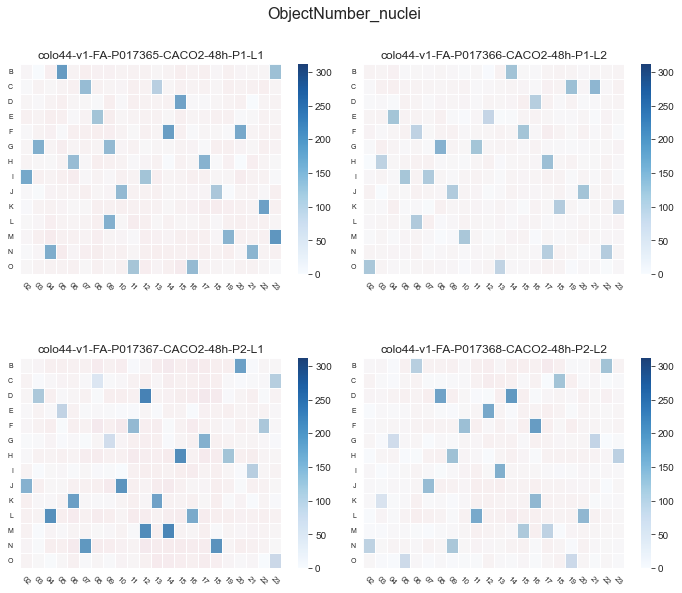

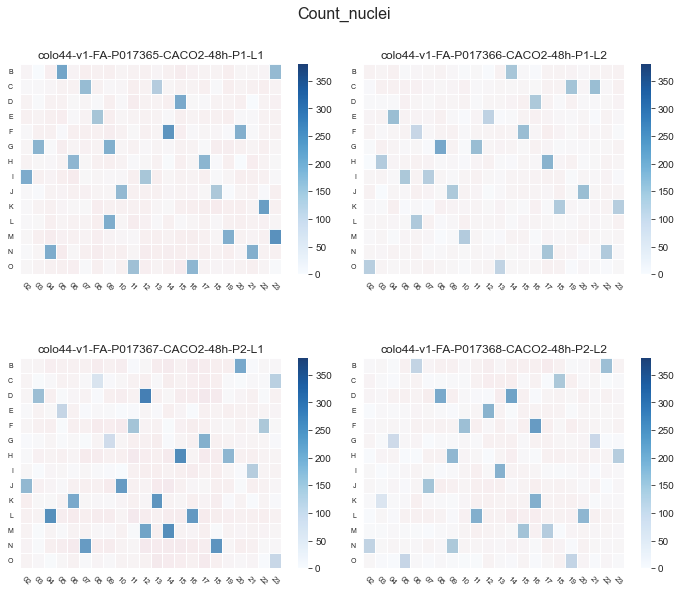

In [10]:
for feature in FeaturesToPlot[:]:
    fig = plt.figure(figsize = HeatmapSize) # Check if I can optimize the size for my purpose
    fig.suptitle('{}'.format(feature)  , fontsize = 16, y=1.1) 

    OneFeature = df[[feature, 'well_id', 'barcode', 'compound']]
    OneFeatureDMSO = OneFeature.loc[(OneFeature['compound'] == '[dmso]'), [feature, 'well_id', 'barcode', 'compound']]

    # Set up the heatmap boundaries
    vmed = math.ceil(OneFeature[feature].quantile(0.5)*1000)/1000
    vmed_DMSO = math.ceil(OneFeatureDMSO[feature].quantile(0.5)*1000)/1000
    vmin = 0 

    n = 1 # subplot counter

    for OnePlate in listOfPlates:
        OneFeaturePerPlate = OneFeature[OneFeature['barcode'] == OnePlate]
        OneFeaturePerPlateDMSO = OneFeatureDMSO[OneFeatureDMSO['barcode'] == OnePlate]

        dictOfnumeric = {feature : np.median} 
        groupedby = OneFeaturePerPlate.groupby(['well_id']).agg(dictOfnumeric) # Aggregate to one value per well
        groupedbyDMSO = OneFeaturePerPlateDMSO.groupby(['well_id']).agg(dictOfnumeric)

        # Remove non-exisiting wells
        for W in Wells:
            if W not in groupedby.index:
                groupedby.loc[W] = 0
            if W not in groupedbyDMSO.index:
                groupedbyDMSO.loc[W] = 0
        groupedby.sort_index(inplace=True) 
        groupedbyDMSO.sort_index(inplace=True) 

        # Prepare the data for plotting
        groupedbyvalues = groupedby[feature].values.copy()
        groupedbyvalues.resize(NrOfRows,int(NrOfColumns))
        groupedbydf = pd.DataFrame(groupedbyvalues)
        groupedbydf.columns = Columns
        groupedbydf.index = Rows

        # Prepare the DMSO data for plotting
        groupedbyvaluesDMSO = groupedbyDMSO[feature].values.copy()
        groupedbyvaluesDMSO.resize(NrOfRows,int(NrOfColumns))
        groupedbydfDMSO = pd.DataFrame(groupedbyvaluesDMSO)
        groupedbydfDMSO.columns = Columns
        groupedbydfDMSO.index = Rows
        
        # Subplots 
        ax = fig.add_subplot(Ro, Co , n)
        ax = sns.heatmap(groupedbydf, cmap=cmap, # all data
                                     vmin = vmin,
                                     vmax = vmed * 3,
                                     square = False,
                                     linewidths = .5,
                                     xticklabels = 1, yticklabels = groupedbydf.index,
                                     cbar = False
                                     )
        ax2 = sns.heatmap(groupedbydfDMSO, cmap=cmap2, # DMSO controls
                                     vmin = vmin,
                                     vmax = vmed_DMSO * 2.5,
                                     square = False,
                                     linewidths = .5,
                                     alpha = 0.92
                                     #xticklabels = 1, yticklabels = groupedbydf.index,
                                     )
        plt.yticks(fontsize=7,rotation=0)
        plt.xticks(fontsize=8,rotation= -45) 

        ax.set_title(OnePlate, fontsize = 12, loc = 'center')
        plt.subplots_adjust(  wspace = wspace, hspace = hspace, top = top)
        n += 1

    fig.savefig('{}/Heatmaps_{}_cmap_{}.{}'.format(OutputDir, feature, cmap2, figformat),  dpi=dpi, bbox_inches='tight')

#### Normalize heatmaps using Loess regression as recommended by Andreina
I don't really want to keep this here. But for now I guess it is fine. 

#### Inspiration 

https://pypi.org/project/loess/

https://github.com/pharmbio/plaid/blob/main/simulations/PLAID-bioseminar-plots-2021.ipynb

https://github.com/pharmbio/plaid/blob/main/simulations/libraries/normalization.py 


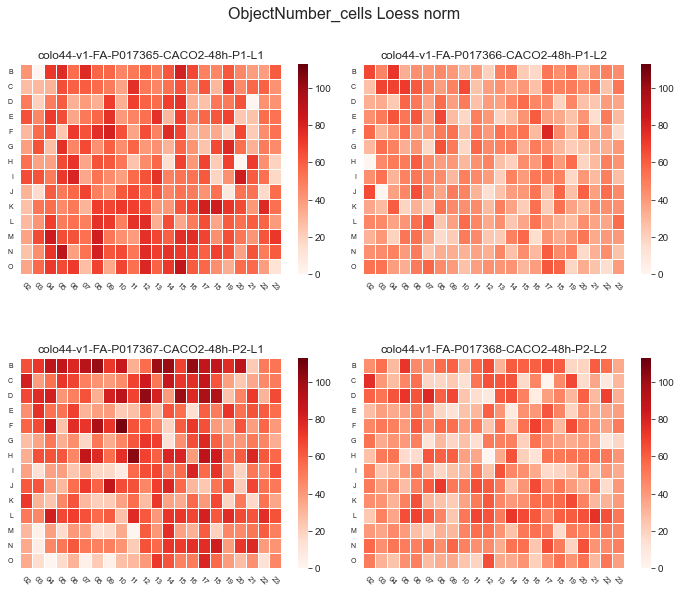

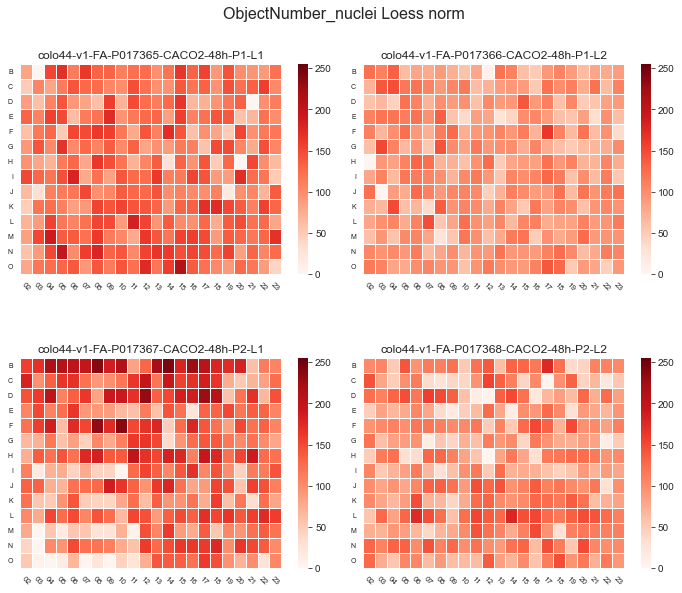

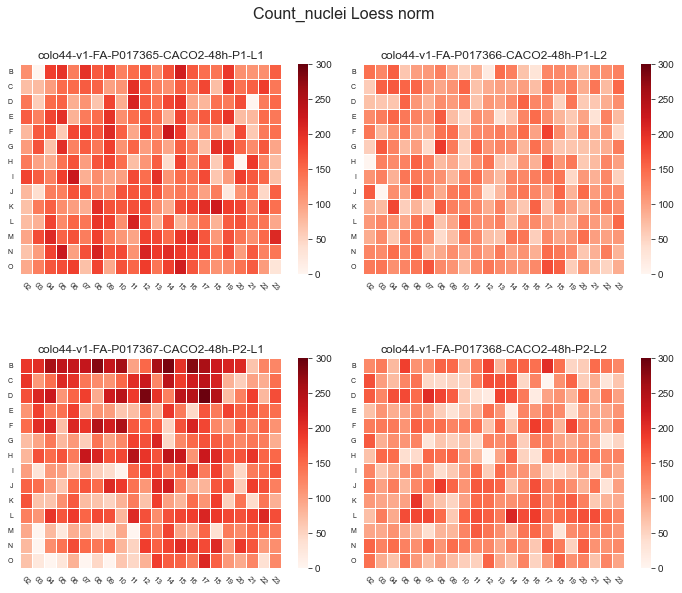

In [17]:
for feature in FeaturesToPlot[:]:
    fig = plt.figure(figsize = HeatmapSize) # Check if I can optimize the size for my purpose
    fig.suptitle('{}'.format(feature) + " Loess norm", fontsize = 16, y=1.1) 

    OneFeature = df[[feature, 'well_id', 'barcode', 'compound']]
    OneFeatureDMSO = OneFeature.loc[(OneFeature['compound'] == '[dmso]'), [feature, 'well_id', 'barcode', 'compound']]

    # Set up the heatmap boundaries
    vmed = math.ceil(OneFeature[feature].quantile(0.5)*1000)/1000
    vmed_DMSO = math.ceil(OneFeatureDMSO[feature].quantile(0.5)*1000)/1000
    vmin = 0 

    n = 1 # subplot counter

    for OnePlate in listOfPlates:
        OneFeaturePerPlate = OneFeature[OneFeature['barcode'] == OnePlate]
        OneFeaturePerPlateDMSO = OneFeatureDMSO[OneFeatureDMSO['barcode'] == OnePlate]

        dictOfnumeric = {feature : np.median} 
        groupedby = OneFeaturePerPlate.groupby(['well_id']).agg(dictOfnumeric) # Aggregate to one value per well
        groupedbyDMSO = OneFeaturePerPlateDMSO.groupby(['well_id']).agg(dictOfnumeric)

        # Apply the loess normalization
        # Prepare the data: DMSO 
        groupedbyDMSO = OneFeaturePerPlateDMSO.groupby(['well_id']).agg(dictOfnumeric)
        groupedbyDMSO["columns"] = groupedbyDMSO.index.str[:1]
        groupedbyDMSO["columns"] = [ ord(x) - 64 for x in groupedbyDMSO["columns"]]
        groupedbyDMSO["rows"] = groupedbyDMSO.index.str[1:3].str.lstrip('0')
        groupedbyDMSO["rows"] = groupedbyDMSO["rows"].astype(int)

        x = groupedbyDMSO[["columns"]].to_numpy().reshape((-1,))
        y = groupedbyDMSO[["rows"]].to_numpy().reshape((-1,))
        z = groupedbyDMSO[feature].to_numpy().reshape((-1,))

        # Prepare the data: all wells 
        groupedby = OneFeaturePerPlate.groupby(['well_id']).agg(dictOfnumeric) # Aggregate to one value per well
        groupedby["columns"] = groupedby.index.str[:1]
        groupedby["columns"] = [ ord(x) - 64 for x in groupedby["columns"]]
        groupedby["rows"] = groupedby.index.str[1:3].str.lstrip('0')
        groupedby["rows"] = groupedby["rows"].astype(int)

        xnew = groupedby[["columns"]].to_numpy().reshape((-1,))
        ynew = groupedby[["rows"]].to_numpy().reshape((-1,))
        znew = groupedby[feature].to_numpy().reshape((-1,))

        # The actual normalization 
        zout, _ = loess_2d(x, y, z, xnew=xnew, ynew=ynew, degree=1, frac=1.0, npoints=None, rescale=False, sigz=None) # estimations of the curves 
        zout_controls, _ = loess_2d(x, y, z, degree=1, frac=1.0, npoints=None, rescale=False, sigz=None)
        z_norm = znew - zout + np.nanmean(zout_controls) # calculation of the normalized data
        
        groupedby["z_norm"] = z_norm

        # Remove non-exisiting wells
        for W in Wells:
            if W not in groupedby.index:
                groupedby.loc[W] = 0
        groupedby.sort_index(inplace=True) 

        ## OBS: here is the problem! 

        # Prepare data for plotting
        groupedbyvalues = groupedby["z_norm"].values.copy()
        groupedbyvalues = groupedbyvalues.reshape(NrOfRows,int(NrOfColumns))
        groupedby_z_norm = pd.DataFrame(groupedbyvalues)
        groupedby_z_norm.columns = Columns
        groupedby_z_norm.index = Rows

        # Subplots 
        ax = fig.add_subplot(Ro, Co , n)
        ax = sns.heatmap(groupedby_z_norm, cmap=cmap, # all data
                                     vmin = vmin,
                                     vmax = vmed * 2.5,
                                     square = False,
                                     linewidths = .5,
                                     xticklabels = 1, yticklabels = groupedby_z_norm.index,
                                     )

        plt.yticks(fontsize=7,rotation=0)
        plt.xticks(fontsize=8,rotation= -45) 

        ax.set_title(OnePlate, fontsize = 12, loc = 'center')
        plt.subplots_adjust(  wspace = wspace, hspace = hspace, top = top)
        n += 1